## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
!nvidia-smi

Sat Mar  5 08:09:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [4]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], 
              kernel_regularizer=l2(1e-4)):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=kernel_regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
RATIO = [1e-2, 1e-4, 1e-8]
REGULARIZER = ["l1", "l2", "l1_l2"]

def CreateRegularizer(reg, reg_ratio):
    if reg == "l1":
        return l1(reg_ratio)
    if reg == "l2":
        return l2(reg_ratio)
    if reg == "l1_l2":
        return l1_l2(l1=reg_ratio, l2=reg_ratio)

In [8]:
results = {}

for reg in REGULARIZER:
    for reg_ratio in RATIO:
        keras.backend.clear_session() # 把舊的 Graph 清掉

        print(f"Experiment with Regularizer = {reg}({reg_ratio:.0e})")
        
        kernel_regularizer = CreateRegularizer(reg, reg_ratio)
        model = build_mlp(input_shape=x_train.shape[1:], kernel_regularizer=kernel_regularizer)

        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        history = model.fit(x_train, y_train, 
                            epochs=EPOCHS, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(x_test, y_test), 
                            shuffle=True, 
                            verbose=0)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = (f"Regularizer: {reg}({reg_ratio:.0e})")
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}



Experiment with Regularizer = l1(1e-02)
Experiment with Regularizer = l1(1e-04)
Experiment with Regularizer = l1(1e-08)
Experiment with Regularizer = l2(1e-02)
Experiment with Regularizer = l2(1e-04)
Experiment with Regularizer = l2(1e-08)
Experiment with Regularizer = l1_l2(1e-02)
Experiment with Regularizer = l1_l2(1e-04)
Experiment with Regularizer = l1_l2(1e-08)


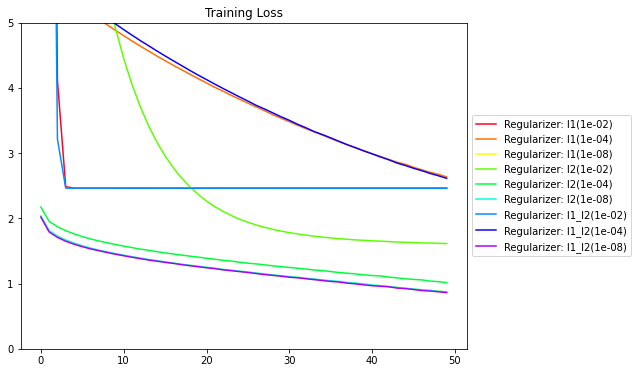

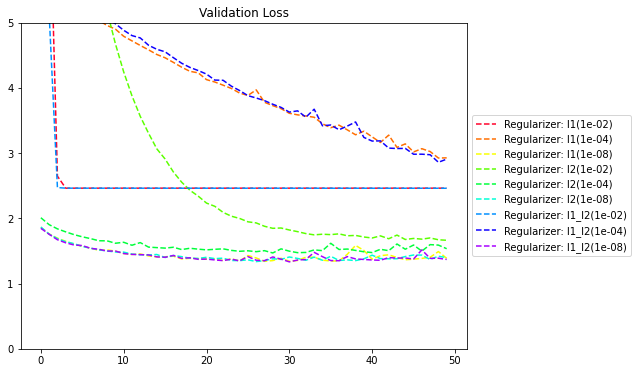

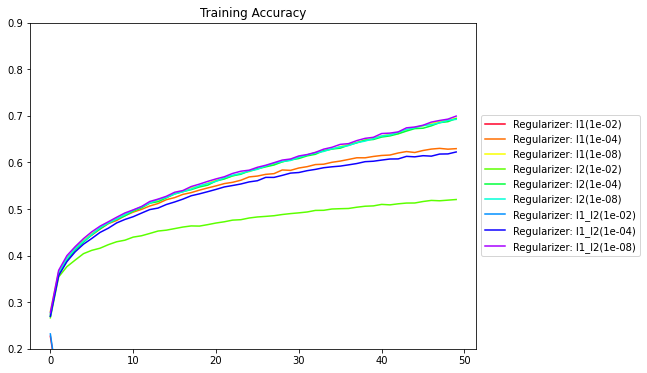

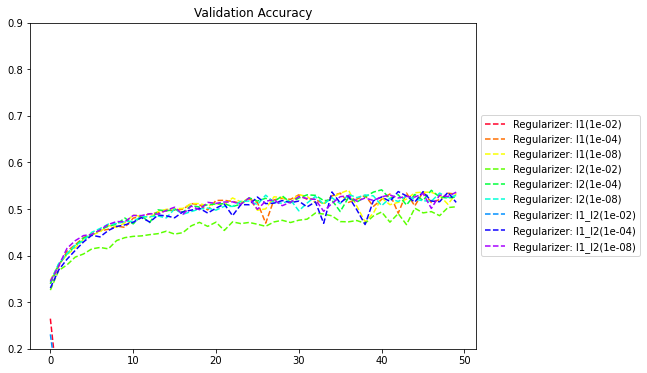

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Accuracy")
plt.ylim([0.2, 0.9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Accuracy")
plt.ylim([0.2, 0.9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()